# Mean-smoothing filter
Mean-smooth filter is useful if noise is distributed equaly in positive and negative derections around clean signal


In [1]:
# MEAN-SMOOTHING FILTER
%cd AI/BCI/courses/signal_processing/1.denoising
import numpy as np
import matplotlib.pyplot as plt


sampling_rate = 256
time = np.arange(0, 3, 1 / sampling_rate)  # 256 * 3 seconds
n_interpolation_pole = 15  # real number of data points before interpolation
n_data = len(time)  # number of data points after interpolation
data_amplitude = 30
noise_amplitude = 5

clean_signal = np.random.random(n_interpolation_pole) * data_amplitude
clean_signal = np.interp(time, np.linspace(0, 3, n_interpolation_pole), clean_signal)
noise = np.random.uniform(-1, 1, n_data) * noise_amplitude
noisy_signal = clean_signal + noise

plt.figure(figsize=(15, 7))
plt.plot(time, noisy_signal, label='noisy signal')
plt.plot(time, clean_signal, label='clean signal')
plt.legend()


C:\Users\Viacheslav_Bobrov\AI\BCI\courses\signal_processing\1.denoising


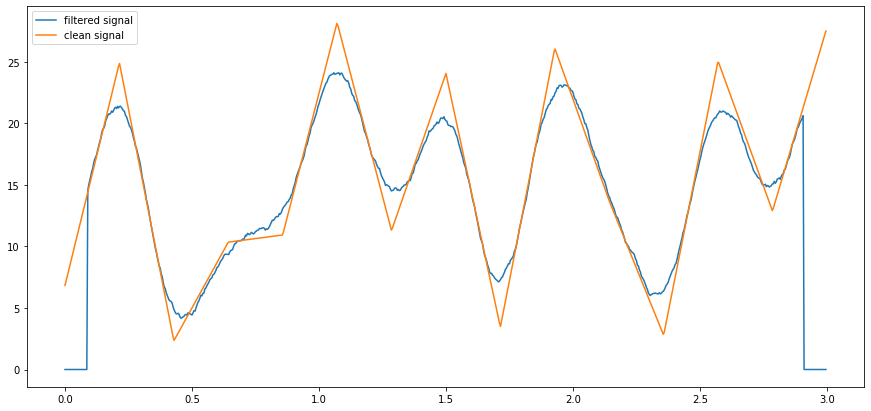

In [69]:

k = 22  # Filter window = k*2+1, the bigger k, the smoother is signal
mean_filtered_signal = np.zeros(n_data)

for i in range(k + 1, n_data - k - 1):
    mean_filtered_signal[i] = np.mean(noisy_signal[i - k:i + k])

plt.figure(figsize=(15, 7))
plt.plot(time, clean_signal, label='clean signal')
plt.plot(time, mean_filtered_signal, label='filtered signal')

plt.legend()


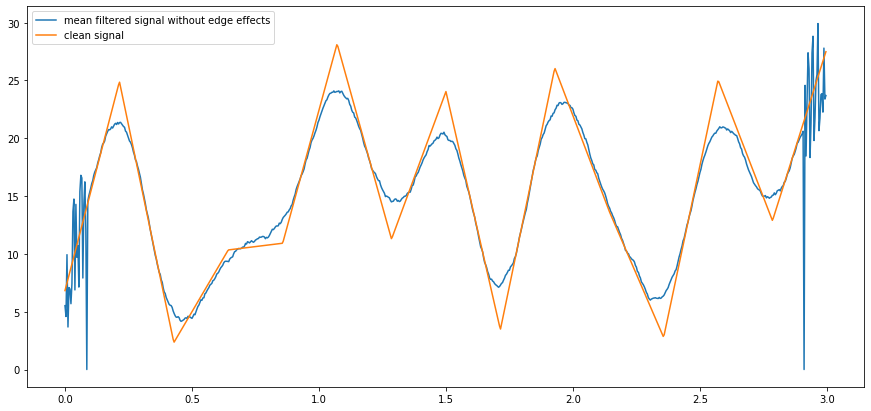

In [70]:
mean_filtered_signal_without_edge_effects = noisy_signal
mean_filtered_signal_without_edge_effects[k:-k] = mean_filtered_signal[k:-k]

plt.figure(figsize=(15, 7))
plt.plot(time, clean_signal, label='clean signal')
plt.plot(time, mean_filtered_signal_without_edge_effects, label='mean filtered signal without edge effects')
plt.legend()

# Gaussian-smoothing filter
Usuall used instead of mean-smoothing filter

Text(0.5, 1.0, 'Gaussian kernel with full_width_half_maximum = 40')

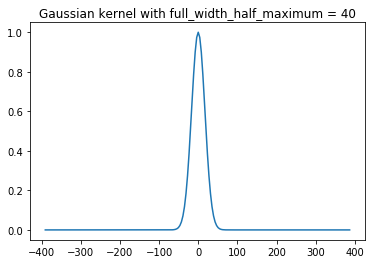

In [71]:
# GAUSSIAN-SMOOTHING FILTER
full_width_half_maximum = 40  # ms, influences width of the 'bell' shape

k = 100  # k should be large enough for the Gaussian curve to touch the x axis on sides
gaussian_time = 1000 * np.arange(-k, k) / sampling_rate
gaussian_window = np.exp(-(4 * np.log(2) * (gaussian_time ** 2)) / full_width_half_maximum ** 2)

plt.plot(gaussian_time, gaussian_window)
plt.title('Gaussian kernel with full_width_half_maximum = %d' % full_width_half_maximum)


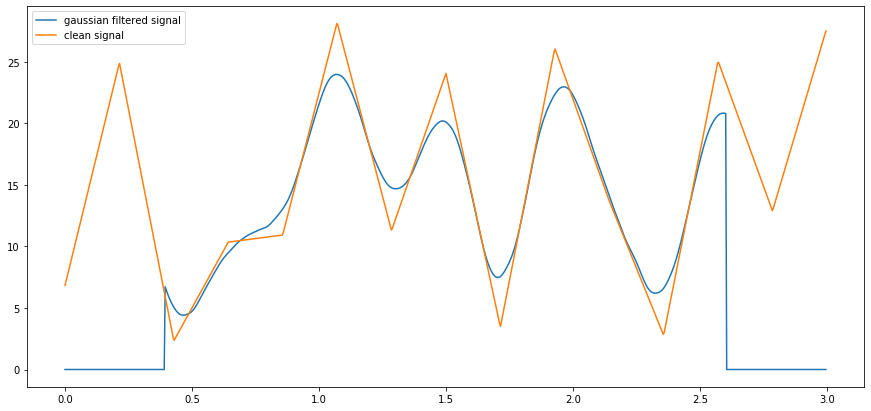

In [72]:
# scaling gaussian_window to the scale of the data (otherwise its amplitude is much larger)
gaussian_window = gaussian_window / sum(gaussian_window)

gaussian_filtered_signal = np.zeros(n_data)

for i in range(k + 1, n_data - k - 1):
    gaussian_filtered_signal[i] = sum(noisy_signal[i - k:i + k] * gaussian_window)

plt.figure(figsize=(15, 7))
plt.plot(time, clean_signal, label='clean signal')
plt.plot(time, gaussian_filtered_signal, label='gaussian filtered signal')
plt.title('Zoomed in version')
plt.legend()

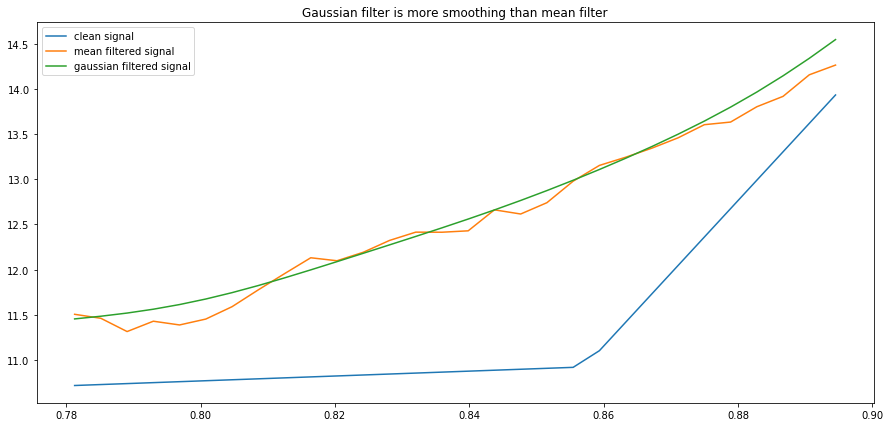

In [82]:
plt.figure(figsize=(15, 7))
plt.plot(time[200:230], clean_signal[200:230], label='clean signal')
plt.plot(time[200:230], mean_filtered_signal[200:230], label='mean filtered signal')
plt.plot(time[200:230], gaussian_filtered_signal[200:230], label='gaussian filtered signal')
plt.title('Gaussian filter is more smoothing than mean filter')
plt.legend()

# Gaussian-Smoothing filter for spikes


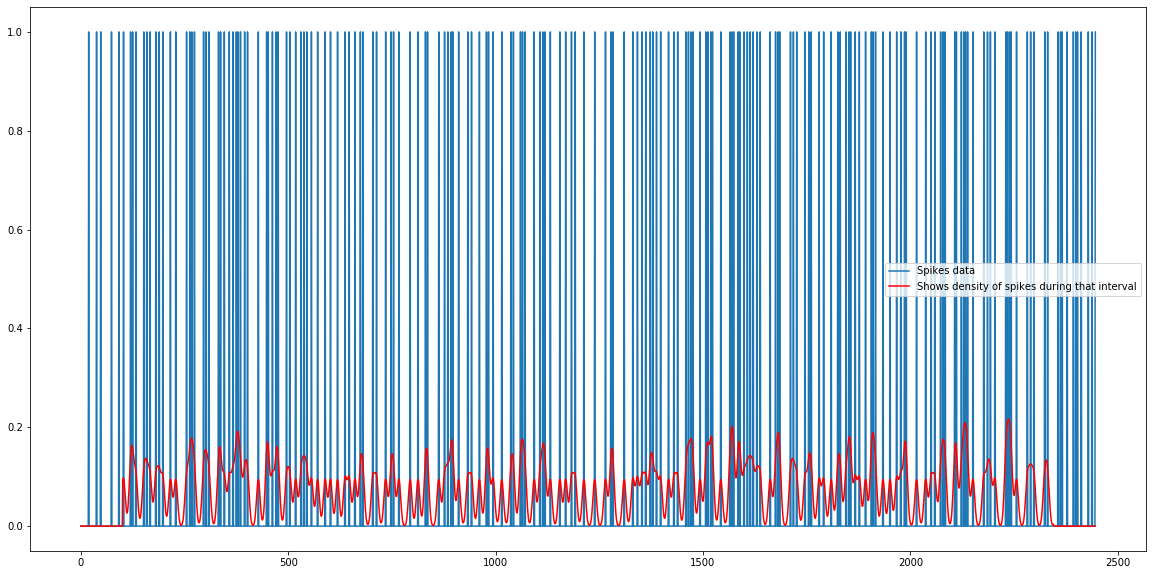

In [107]:
# GAUSSIAN-SMOOTHING FILTER FOR SPIKES

# Data generation

n_spikes = 200

inter_spike_interval = np.round(np.exp(np.random.uniform(-1, 1, n_spikes)) * 10).astype(int)
n_spikes_data = sum(inter_spike_interval) + 1
spikes_signal = np.zeros(n_spikes_data)

data_pointer = 0
for i in range(n_spikes):
    spikes_signal[data_pointer + inter_spike_interval[i]] = 1
    data_pointer += inter_spike_interval[i]

# Gaussian filter 

full_width_half_maximum_s = 10  # ms, influences to what extent spikes will be smoothed out
k = 100  # window size = k*2+1 (data that a single point will be calculated from)
gaussian_time_s = np.arange(-k, k)
gaussian_window_s = np.exp(-(4 * np.log(2) * (gaussian_time_s ** 2)) / full_width_half_maximum_s ** 2)
gaussian_window_s = gaussian_window_s / sum(gaussian_window_s)

gaussian_spike_smoothed_signal = np.zeros(n_spikes_data)
for i in range(k + 1, n_spikes_data - k - 1):
    gaussian_spike_smoothed_signal[i] = sum(spikes_signal[i - k:i + k] * gaussian_window_s)

plt.figure(figsize=(20, 10))
plt.plot(spikes_signal, label='Spikes data')
plt.plot(gaussian_spike_smoothed_signal, label='Shows density of spikes during that interval', color='r')
plt.legend()


# Denoising with Teager-Keiser Energy Operator 
y = Xt^2 - Xt-1 * Xt+1 - if curent step t is of high amplitude compared to t-1 and t+1, it gets enlarged.
If t, t-1 and t-2 are similar (like low amplitude noise), they cancelled out to 0

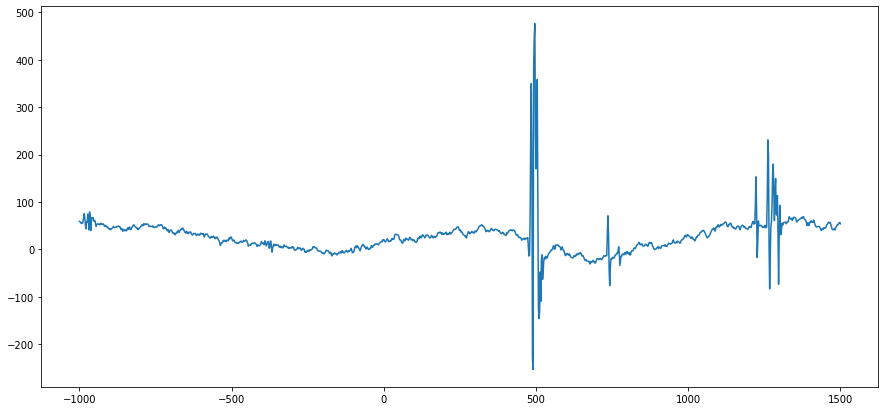

In [2]:
# TEAGER-KEISER ENERGY OPERATOR
from scipy.io import loadmat
emg_mat = loadmat('emg4TKEO.mat')
emg_signal = emg_mat['emg'][0]
emg_time = emg_mat['emgtime'][0]
emg_sample_frequency = emg_mat['fs'][0]

plt.figure(figsize=(15, 7))
plt.plot(emg_time, emg_signal)

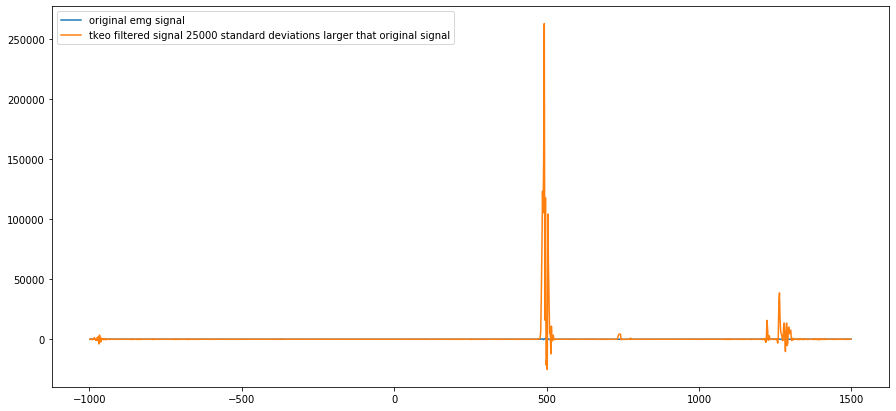

In [138]:
#Xt^2 - Xt-1 * Xt+1
tkeo_filtered_signal = emg_signal[1:-1] ** 2 - emg_signal[0:-2] * emg_signal[2:]

plt.figure(figsize=(15, 7))
plt.plot(emg_time[1:-1], emg_signal[1:-1], label='original emg signal')
plt.plot(emg_time[1:-1], tkeo_filtered_signal,
         label='tkeo filtered signal 25000 standard deviations larger that original signal')
plt.legend()


Text(0.5, 1.0, 'Both signals are normalized to fit in one scale')

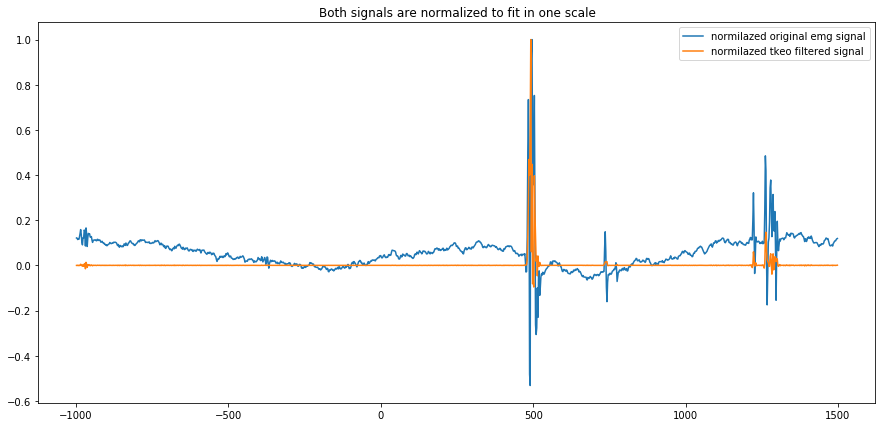

In [141]:
plt.figure(figsize=(15, 7))
plt.plot(emg_time[1:-1], emg_signal[1:-1] / max(emg_signal[1:-1]), label='normilazed original emg signal')
plt.plot(emg_time[1:-1], tkeo_filtered_signal / max(tkeo_filtered_signal),
         label='normilazed tkeo filtered signal ')
plt.legend()
plt.title('Both signals are normalized to fit in one scale')


# Median Filter To Remove Spike Noise
Apply to selected data points, not all data points

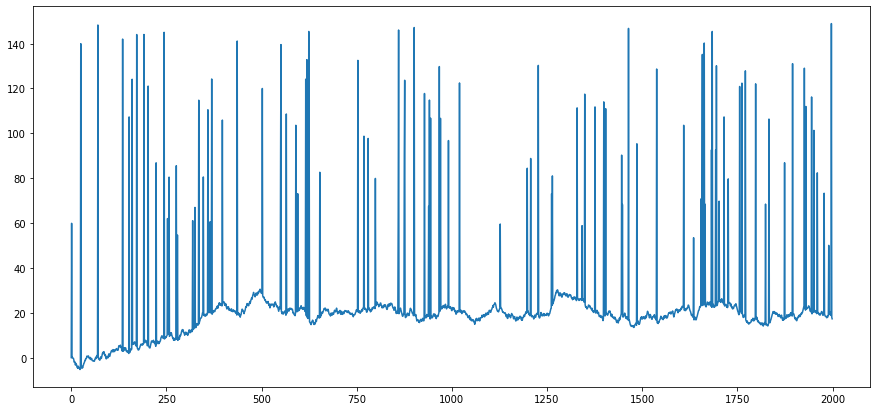

In [211]:
# MEDIAN FILTER TO REMOVE SPIKE NOISE
n_spiked_signal = 2000
spiked_signal = np.cumsum(np.random.uniform(-1, 1, n_spiked_signal))

spike_percentage = 0.05
# Pick random indecies to be spikes
spike_indices = np.random.permutation(n_spiked_signal)
spike_indices = spike_indices[1:round(n_spiked_signal * spike_percentage)]

#Create spikes
spiked_signal[spike_indices] = 50 + np.random.rand(len(spike_indices)) * 100

plt.figure(figsize=(15, 7))
plt.plot(spiked_signal)


Text(0.5, 1.0, 'Amplitude distribution, from which we define spikes threshold')

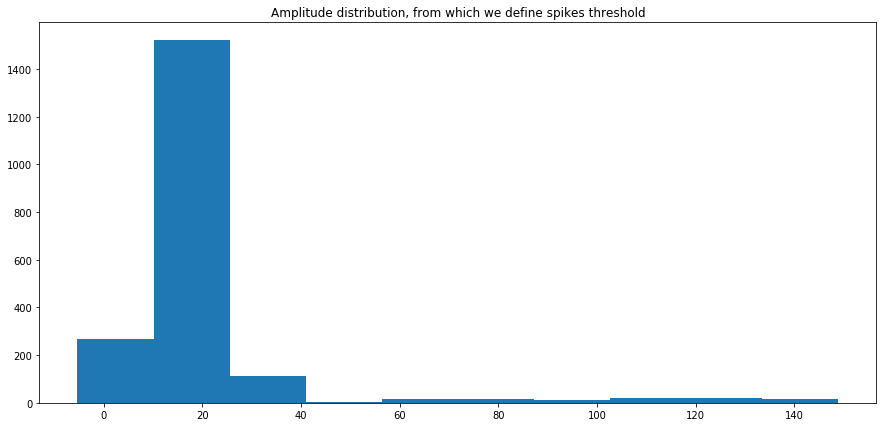

In [214]:
plt.figure(figsize=(15, 7))
plt.hist(spiked_signal)
plt.title('Amplitude distribution, from which we define spikes threshold')

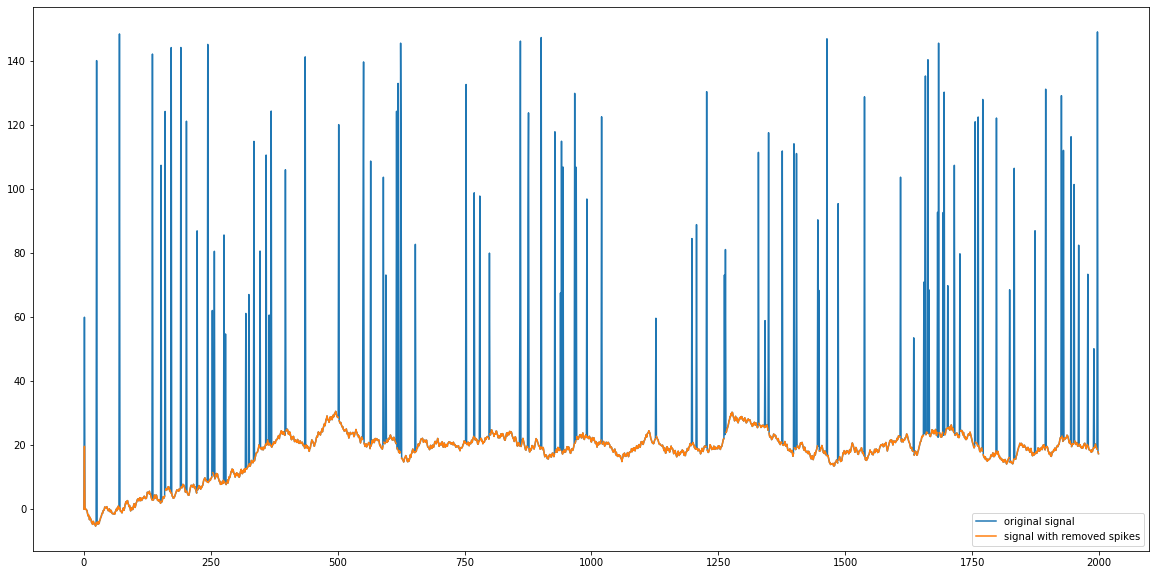

In [218]:
non_spike_threshold = 42  # taken from hist above

supra_threshold_indices = np.argwhere(spiked_signal > non_spike_threshold).ravel()
spike_filtered_signal = np.copy(spiked_signal)
k = 20  # window = k * 2 + 1, for local median
for i in range(len(supra_threshold_indices)):
    lower_bound = max(supra_threshold_indices[i] - k, 0)  # max to prevent negative indices
    upper_bound = min(supra_threshold_indices[i] - k,
                      len(supra_threshold_indices) - 1)  # min to prevent negative indices > length
    spike_filtered_signal[supra_threshold_indices[i]] = np.median(spiked_signal[lower_bound:upper_bound])

plt.figure(figsize=(20, 10))
plt.plot(spiked_signal, label='original signal')
plt.plot(spike_filtered_signal, label='signal with removed spikes')
plt.legend()


# Removing Linear Trend

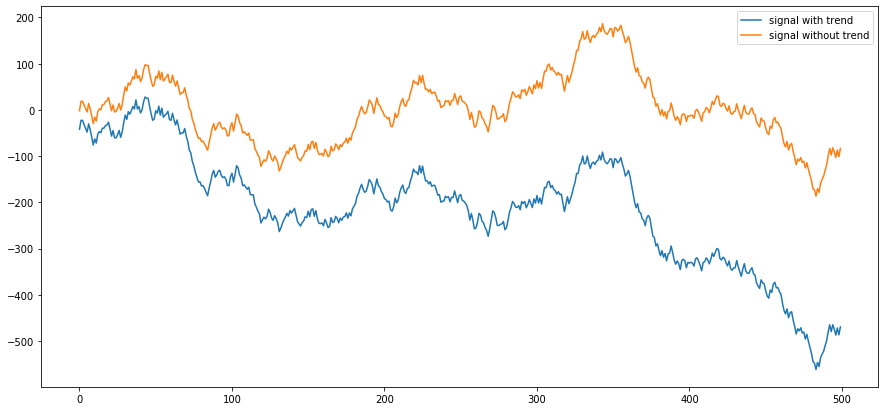

In [239]:
# REMOVING LINEAR TREND
from scipy.signal import detrend

signal_with_trend = np.cumsum(np.random.uniform(-20, 20, 500)) + np.linspace(-30, 30, 500)

# Using linear regression finds the line that fits trough trended signal and then subtracts this line
# from the signal to remove the angle of trend
detrened_signal = detrend(signal_with_trend)

plt.figure(figsize=(15, 7))
plt.plot(signal_with_trend, label='signal with trend')
plt.plot(detrened_signal, label='signal without trend')
plt.legend()

Text(0.5, 1.0, 'Signals with mean over 707 trials')

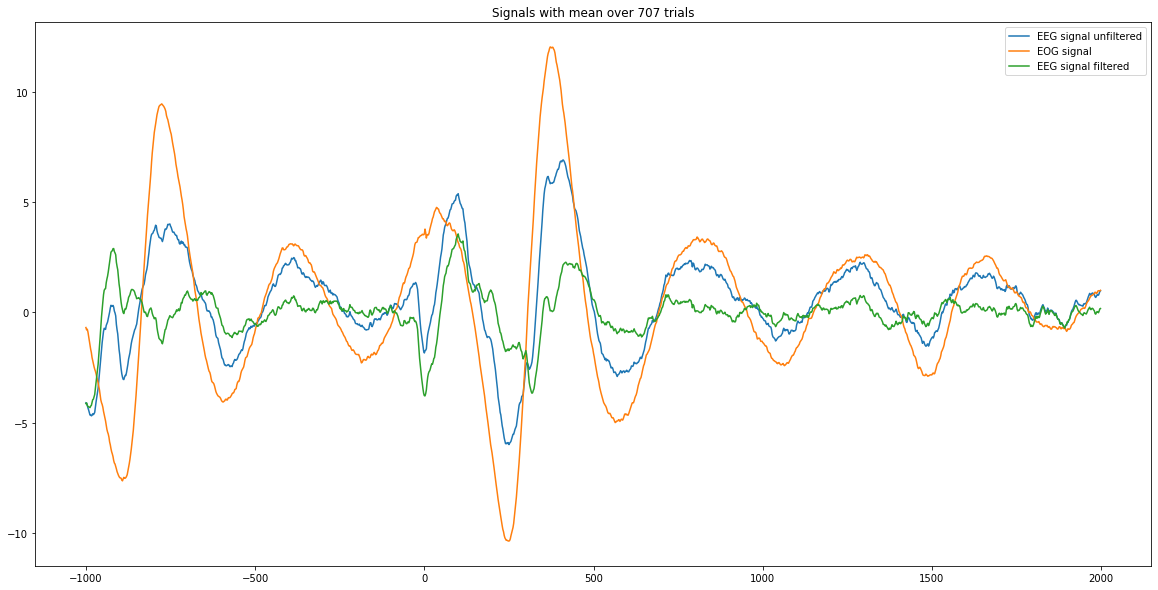

In [40]:
# REMOVE ARTIFACT VIA LEAST-SQUARES TEMPLATE-MATCHING
from numpy.linalg import inv

eeg_mat = loadmat('templateProjection.mat')
eeg_trials = eeg_mat['EEGdat']  # [time; trials]
eog_trials = eeg_mat['eyedat']  # eye blinks artifact channel
eeg_time = eeg_mat['timevec'][0]

residual = np.zeros(shape=eeg_trials.shape)
for trial_i in range(eeg_trials.shape[1]):
    X = np.column_stack((np.ones((eeg_trials.shape[0], 1)), eog_trials[:, trial_i]))
    b = inv(X.T.dot(X)).dot(X.T).dot(eeg_trials[:, trial_i].reshape(-1, 1))
    yHat = X.dot(b).ravel()
    residual[:, trial_i] = eeg_trials[:, trial_i] - yHat

plt.figure(figsize=(20, 10))
plt.plot(eeg_time, np.mean(eeg_trials, axis=1), label='EEG signal unfiltered')
plt.plot(eeg_time, np.mean(eog_trials, axis=1), label='EOG signal')
plt.plot(eeg_time, np.mean(residual, axis=1), label='EEG signal filtered')
plt.legend()
plt.title('Signals with mean over %s trials' % eeg_trials.shape[1])
